# Ocean data handling

In this notebook we show how ocean data is handled.

In [1]:
# NBVAL_IGNORE_OUTPUT
import traceback
from os.path import join
    
import expectexception
import numpy as np
import iris
import iris.quickplot as qplt
import matplotlib
import matplotlib.pyplot as plt
from openscm.scmdataframe import ScmDataFrame

from netcdf_scm.iris_cube_wrappers import CMIP6OutputCube

<IPython.core.display.Javascript object>

In [2]:
# make all logs apper
import logging
root_logger = logging.getLogger()
root_logger.addHandler(logging.StreamHandler())

In [3]:
plt.style.use('bmh') 
%matplotlib inline

In [4]:
DATA_PATH_TEST = join("..", "tests", "test-data")
DATA_PATH_TEST_CMIP6_OUTPUT_ROOT = join(DATA_PATH_TEST, "cmip6output")

## Test data

For this notebook's test data we use CMIP6Output from NCAR's CESM2 model.

### 2D data

Some ocean data is 2D. Here we use surface downward heat flux in sea water.

Firstly we use data which has been regridded by the modelling group.

In [5]:
hfds_file = join(
    DATA_PATH_TEST_CMIP6_OUTPUT_ROOT,
    "CMIP6",
    "CMIP",
    "NCAR",
    "CESM2",
    "historical",
    "r4i1p1f1",
    "Omon",
    "hfds",
    "gr",
    "v20190308",
    "hfds_Omon_CESM2_historical_r4i1p1f1_gr_185001-185006.nc",
)

We also examine how iris handles data which is provided on the native model grid.

In [6]:
hfds_file_gn = hfds_file.replace("gr", "gn")

### 3D data

Some ocean data is 3D. Here we use seawater potential temperature.

In [7]:
thetao_file = join(
    DATA_PATH_TEST_CMIP6_OUTPUT_ROOT,
    "CMIP6",
    "CMIP",
    "NCAR",
    "CESM2-WACCM",
    "piControl",
    "r1i1p1f1",
    "Omon",
    "thetao",
    "gr",
    "v20190320",
    "thetao_Omon_CESM2-WACCM_piControl_r1i1p1f1_gr_000101-000103.nc",
)

Once again we have data both on the native model grid as well as the regridded data.

In [8]:
thetao_file_gn = thetao_file.replace("gr", "gn")

## 2D data handling

In [9]:
hfds_cube = CMIP6OutputCube()
hfds_cube.load_data_from_path(hfds_file)

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working


In [10]:
hfds_cube.cube

<iris 'Cube' of surface_downward_heat_flux_in_sea_water / (W m-2) (time: 6; latitude: 180; longitude: 360)>

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working


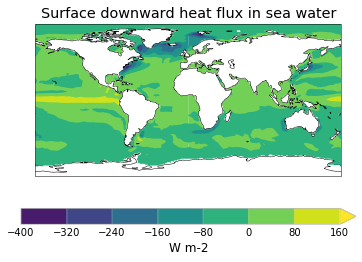

In [11]:
# NBVAL_IGNORE_OUTPUT
time_mean = hfds_cube.cube.collapsed('time', iris.analysis.MEAN)
qplt.contourf(
    time_mean, 
    extend='max',
)
plt.gca().coastlines();

Iris' handling of data on the native model grid is mostly workable, but not yet perfect.

In [12]:
hfds_cube_gn = CMIP6OutputCube()
hfds_cube_gn.load_data_from_path(hfds_file_gn)

hfds_cube_gn.cube

<iris 'Cube' of surface_downward_heat_flux_in_sea_water / (W m-2) (time: 6; -- : 384; -- : 320)>

As we can see, iris doesn't plot data on these native model grids well (unlike the regridded data which it handles without problems).

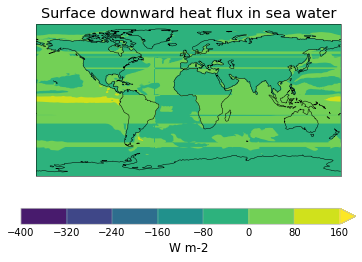

In [13]:
# NBVAL_IGNORE_OUTPUT
time_mean = hfds_cube_gn.cube.collapsed('time', iris.analysis.MEAN)
qplt.contourf(
    time_mean, 
    extend='max',
)
plt.gca().coastlines();

## Getting SCM Cubes

We can get SCM cubes for ocean data in the standard way.

In [14]:
hfds_scm_cubes = hfds_cube.get_scm_cubes(masks=[
    "World",
    "World|Northern Hemisphere",
    "World|Northern Hemisphere|Ocean",
    "World|Ocean",
    "World|Southern Hemisphere",
    "World|Southern Hemisphere|Ocean",
    "World|North Atlantic Ocean",
    "World|El Nino N3.4",
])

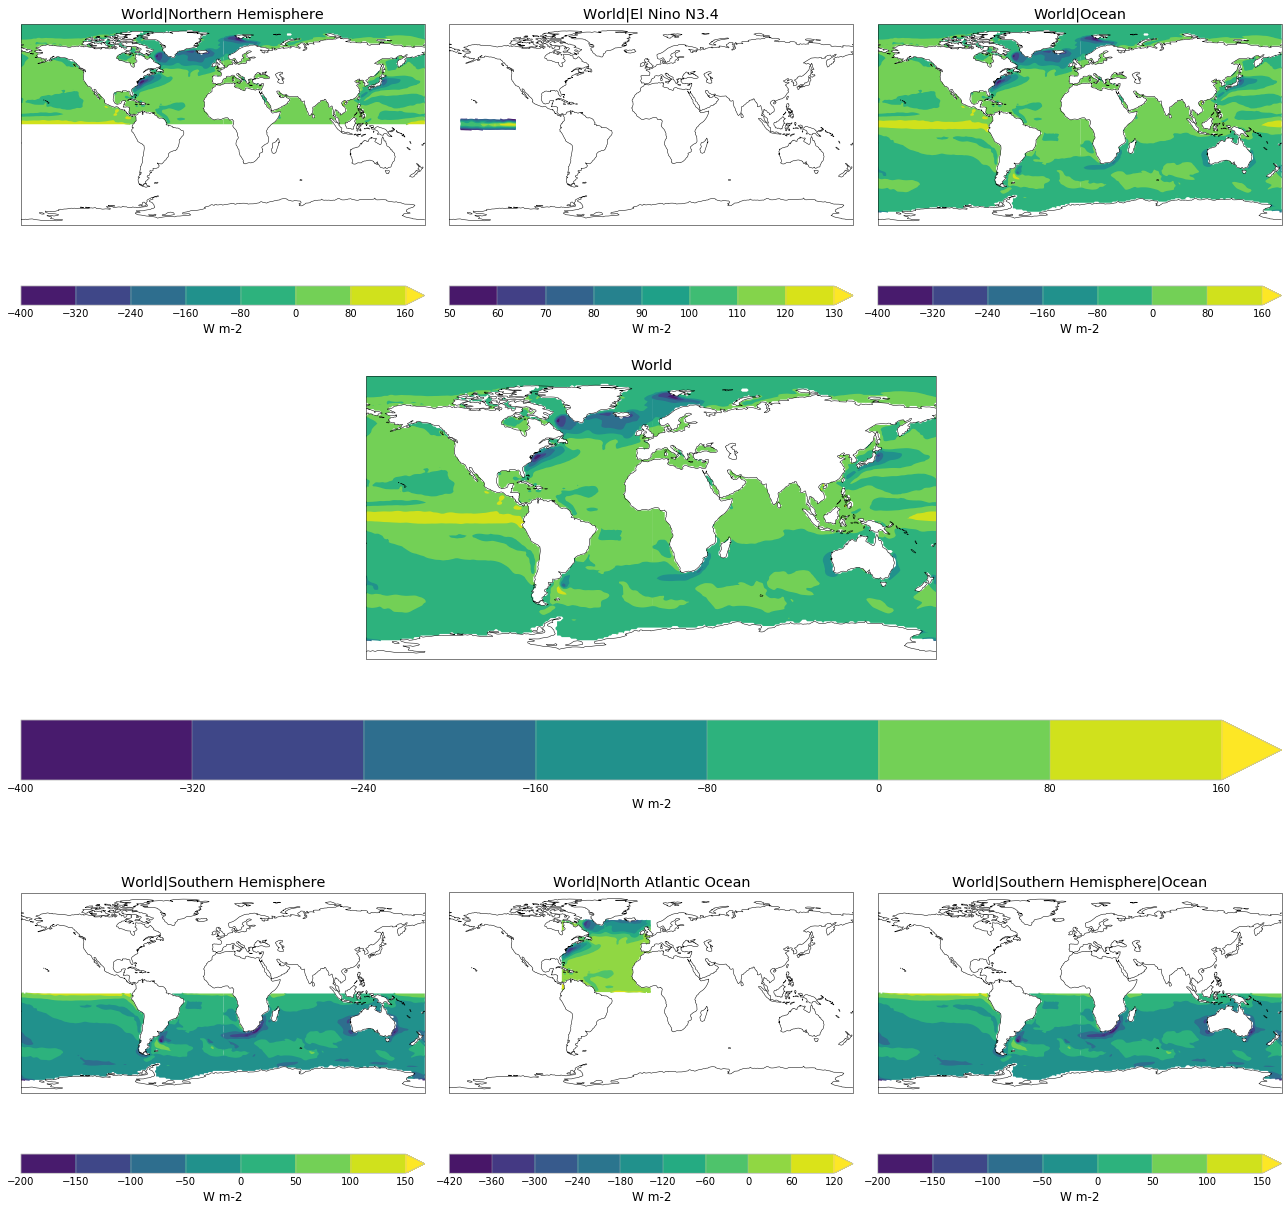

In [15]:
# NBVAL_IGNORE_OUTPUT
plt.figure(figsize=(18, 18))
no_rows = 3
no_cols = 3

total_panels = no_cols * no_rows
rows_plt_comp = no_rows*100
cols_plt_comp = no_cols*10
for i, (label, cube) in enumerate(hfds_scm_cubes.items()):
    if label == "World":
        index = (int((no_rows + 1) / 2))
        plt.subplot(no_rows, 1, index)
    else:
        if label == "World|Northern Hemisphere":
            index = 1
        elif label == "World|Southern Hemisphere":
            index = 1 + (no_rows - 1) * no_cols
        else:
            index = 2
            if "North Atlantic Ocean" in label:
                index += (no_rows - 1) * no_cols
            elif "Ocean" in label:
                index += 1
            if "Southern Hemisphere" in label:
                index += (no_rows - 1) * no_cols
        plt.subplot(no_rows, no_cols, index)
        
    region_time_mean = cube.cube.collapsed('time', iris.analysis.MEAN)
    try:
        qplt.contourf(
            region_time_mean, 
            extend='max',
        )
        plt.title(label)
        plt.gca().coastlines()
    except ValueError:
        print(label)
        
    
plt.tight_layout()

We can also cut down to SCM timeseries in the standard way.

Not calculating land fractions because we don't have all the required cubes
Performing lazy conversion to datetime for calendar: 365_day. This may cause subtle errors in operations that depend on the length of time between dates
cannot be safely cast to variable data type
Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'latitude'.
Collapsing a multi-dimensional coordinate. Metadata may not be fully descriptive for 'longitude'.
Not calculating land fractions because we don't have all the required cubes
Performing lazy conversion to datetime for calendar: 365_day. This may cause subtle errors in operations that depend on the length of time between dates


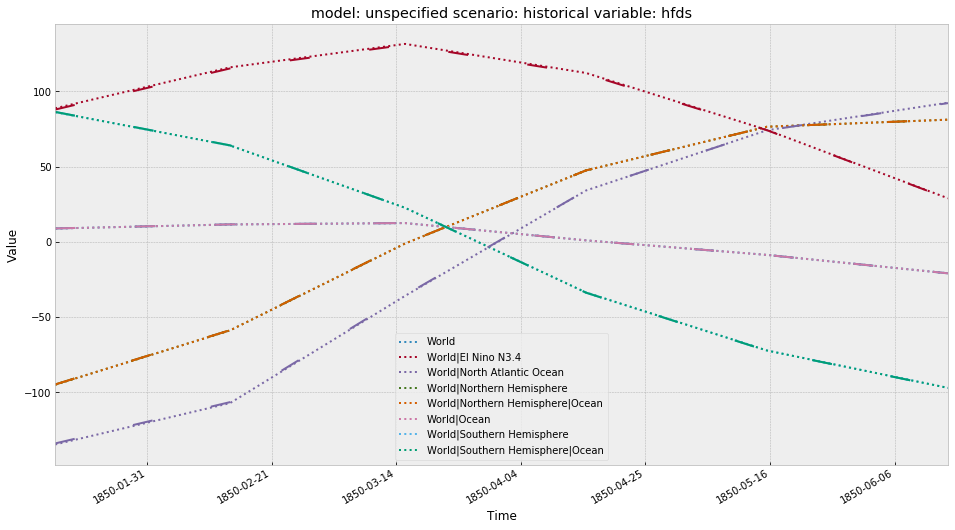

In [16]:
masks_to_get = [
    "World",
    "World|Northern Hemisphere",
    "World|Northern Hemisphere|Ocean",
    "World|Ocean",
    "World|Southern Hemisphere",
    "World|Southern Hemisphere|Ocean",
    "World|North Atlantic Ocean",
    "World|El Nino N3.4",
]
hfds_ts = hfds_cube.get_scm_timeseries(masks=masks_to_get)
hfds_gn_ts = hfds_cube_gn.get_scm_timeseries(masks=masks_to_get)

ax = hfds_ts.line_plot(color="region", linestyle=":", figsize=(16, 9))
hfds_gn_ts.line_plot(color="region", linestyle="--", dashes=(10, 30), ax=ax);

Comparing the results of collapsing the native grid and the regridded data reveals a small difference (approx 1%), in particular in the small El Nino N3.4 region.

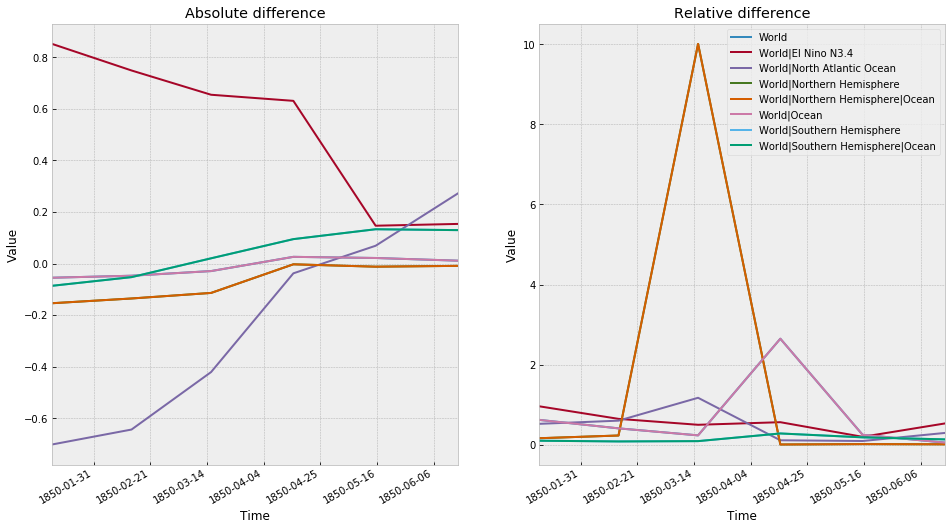

In [17]:
ax1, ax2 = plt.figure(figsize=(16, 9)).subplots(nrows=1, ncols=2)

ScmDataFrame(
    hfds_ts.timeseries() 
    - hfds_gn_ts.timeseries()
).line_plot(color="region", ax=ax1, legend=False)
ax1.set_title("Absolute difference")

ScmDataFrame(
    (
        (hfds_ts.timeseries() - hfds_gn_ts.timeseries()) 
        / hfds_ts.timeseries()
    ).abs() * 100
).line_plot(color="region", ax=ax2)
ax2.set_title("Relative difference");

### Land masks

If we request a land mask, a `ValueError` will be raised. This occurs according to the following logic:

1. NetCDF-SCM automatically decides whether a cube is ocean data or not based on the cube's NetCDF attributes 
1. If the cube is ocean data, then all data is assigned to the ocean boxes
1. Hence if we request land data, nothing will match and we will receive a ValueError

In [18]:
# attribute which shows whether cube is ocean data or not
hfds_cube.is_ocean_data

True

In [19]:
# if we try to get the land mask, an error is raised
try:
    hfds_cube.get_scm_cubes(masks=["World|Land"])
except ValueError as e:
    traceback.print_exc(limit=0, chain=False)

Traceback (most recent call last):
ValueError: Your cube has no data which matches the `World|Land` mask


## 3D data handling

At the moment, crunching SCM timeseries is not possible with data that has more than latitude, longitude and time dimensions. We are working on this but have not yet decided what the best way to put 3D data into an ScmDataFrame (which is itself 2D) is. If you would like to contribute to the conversation, please see [this pull request](https://github.com/znicholls/netcdf-scm/pull/76).